<a id='home'></a>
### purpose


check the overlap of loci used by *GO<sub>geno,ind</sub>* and *GO<sub>AF,pop</sub>* models

1. [get files of trained models](#train)
1. [write sh files to retrieve loci](#write)

    I  retrieve locus names used in GF models by loading the trained object files into R (using command line)
1. [see if any jobs need to be rerun](#run)
1. [look at overlap](#look)
1. [get data](#data)
1. [make figs](#figs)
    1. [venn diagrams](#venn)
    1. [histograms](#hist)
    1. [boxplots](#box)
    1. [scatter plots](#scat)
    1. [compare number of loci within AF and geno datasets](#comp)

In [1]:
from pythonimports import *

import runtime_API as rt

import seaborn as sns

t0 = dt.now()

rt.latest_commit()
session_info.show()

#########################################################
Today:	April 11, 2024 - 09:25:54 EDT
python version: 3.8.5
conda env: mvp_env

Current commit of pythonimports:
commit 6a767410e7b569adbf9df526de108f22ef50aad8  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Wed Mar 6 13:42:13 2024 -0700

Current commit of MVP_offsets:
commit 8b790072e7a46d7f58a30c40cf4660986a612764  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Fri Feb 2 13:55:49 2024 -0500

Current commit of MVP_runtime:
commit df87dd2c708ac0fdeebcfaaca239473ca2c487af  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Tue Mar 19 16:17:46 2024 -0400
#########################################################



<a id='train'></a>
# get files of trained models

get the saved gradientForest objects, these will be used to identify loci with R2 > 0

[top](#home)

In [2]:
training_files = wrap_defaultdict(list, 3)
for (source, rep), repdirs in unwrap_dictionary(rt.dirs):
    for repdir in repdirs:
        gf_training_dir = f'{repdir}/gradient_forests/training/training_outfiles'
        
        # first get pred.RDS files that were completed after training (to ensure full training object)
        predfiles = []
        for f in fs(gf_training_dir, endswith='predOut.RDS'):
            seed = op.basename(f).split('_')[0]
            # keep only 2-trait seeds
            if seed in rt.seeds:
                predfiles.append(f)
        
        # now get the training files
        files = [f.replace('predOut.RDS', 'training.RDS') for f in predfiles]
        
        print(source, rep, op.basename(repdir), len(files))
        training_files[source][rep][repdir] = files

ind run_20220919_0-225 00500 180
ind run_20220919_0-225 05000 180
ind run_20220919_0-225 10000 180
ind run_20220919_0-225 20000 95
ind run_20220919_225-450 00500 180
ind run_20220919_225-450 05000 180
ind run_20220919_225-450 10000 180
ind run_20220919_225-450 20000 90
ind run_20220919_450-675 00500 180
ind run_20220919_450-675 05000 180
ind run_20220919_450-675 10000 180
ind run_20220919_450-675 20000 86
pooled run_20220919_0-225 00500 180
pooled run_20220919_0-225 05000 180
pooled run_20220919_0-225 10000 180
pooled run_20220919_0-225 20000 180
pooled run_20220919_225-450 00500 180
pooled run_20220919_225-450 05000 180
pooled run_20220919_225-450 10000 180
pooled run_20220919_225-450 20000 180
pooled run_20220919_450-675 00500 180
pooled run_20220919_450-675 05000 180
pooled run_20220919_450-675 10000 180
pooled run_20220919_450-675 20000 180


In [3]:
# check on ldpaths fix 
ldpaths_fix = '/home/b.lind/work/r35_ldpaths_text.txt'

read(ldpaths_fix)

['# https://github.com/conda/conda/issues/1679:',
 '#  Internally R_system() calls system() which',
 '# uses /bin/sh to launch various programs. If',
 '# /bin/sh is called with LD_LIBRARY_PATH that',
 '# loads condas shared libraries things break.',
 '#  It may be that not setting LD_LIBRARY_PATH',
 '# causes other things to break, in which case',
 '# R_system() will need to be modified so that',
 '# it calls execve() with an environment which',
 '# has these modifications to LD_LIBRARY_PATH',
 '# removed which may be tricky to orchestrate',
 'if [ "$(uname -s)" = "Linux" ]; then',
 '  return 0',
 'fi',
 ': ${JAVA_HOME=/usr/lib/jvm/java-1.8.0-openjdk-1.8.0.342.b07-1.el7_9.x86_64/jre}',
 ': ${R_JAVA_LD_LIBRARY_PATH=${JAVA_HOME}/lib/amd64/server}',
 'if test -n "/home/b.lind/anaconda3/envs/r35/lib"; then',
 ': ${R_LD_LIBRARY_PATH=${R_HOME}/lib:/home/b.lind/anaconda3/envs/r35/lib}',
 'else',
 ': ${R_LD_LIBRARY_PATH=${R_HOME}/lib}',
 'fi',
 'if test -n "${R_JAVA_LD_LIBRARY_PATH}"; then',
 

<a id='write'></a>
# write sh files to retrieve loci

[top](#home)

In [4]:
mems = {
    'ind': {
        '00500': 3000,
        '05000': 45000,
        '10000': 52000,
        '20000': 73000},
    'pooled': {
        '00500': 2000,
        '05000': 23000,
        '10000': 28000,
        '20000': 52000
    }
}

cpus = {
    '00500' : 10,
    '05000' : 10,
    '10000' : 5,
    '20000' : 5
}

num_cmds = {
    '00500' : 225,
    '05000' : 110,
    '10000' : 10,
    '20000' : 10
}

partition = {
    '00500' : 'lotterhos',
    '05000' : 'lotterhos',
    '10000' : 'short',
    '20000' : 'long'
}

In [5]:
all_files = []
shfiles = []
for (source, rep, repdir), files in unwrap_dictionary(training_files):

    num_loci = op.basename(repdir)
    mem = mems[source][num_loci]
    cpu = cpus[num_loci]
    thresh = num_cmds[num_loci]
    partxn = partition[num_loci]

    shdir = makedir(f'{repdir}/gradient_forests/get_loci_pos_rsq/shfiles')
    filedir = makedir(f'{repdir}/gradient_forests/get_loci_pos_rsq/infiles')
    outdir = makedir(f'{repdir}/gradient_forests/get_loci_pos_rsq/outfiles')

    catfiles = []
    cmds = []
    for rds in pbar(files, desc=f'{source} {num_loci}'):
        seed = op.basename(rds).split("_")[0]
        outfile = f'{outdir}/{seed}_loci_pos_rsq.txt'
        cmd = f'''Rscript -e "rds = '{rds}'; x=readRDS(rds) ; write.table(data.frame(R2=x[['result']]), '{outfile}', sep='\\t', row.names=TRUE)"'''

        cmds.append(cmd)

        if len(cmds) == thresh or rds == files[-1]:
            basename = f'{source}_{rep}_{num_loci}_R_cmds_%s' % str(len(catfiles)).zfill(2)

            catfile = f'{filedir}/{basename}.txt'
            with open(catfile, 'w') as o:
                o.write('\n'.join(cmds))
            catfiles.append(catfile)
            all_files .append(catfile)

            shtext = f'''#!/bin/bash
#SBATCH --job-name={basename}
#SBATCH --partition={partxn}
#SBATCH --nodes=1
#SBATCH --cpus-per-task={cpu}
#SBATCH --time=12:00:00
#SBATCH --mem={mem}M
#SBATCH --output={basename}_%j.out

source $HOME/.bashrc
conda deactivate
conda activate r35

module load parallel

# put a new file in ldpaths if it's not already there
if ! [ -f /home/b.lind/anaconda3/envs/r35/lib/R/etc/ldpaths ]; then
cp {ldpaths_fix} /home/b.lind/anaconda3/envs/r35/lib/R/etc/ldpaths
fi

cat {catfile} | parallel -j {cpu} --progress

'''
            shfile = f'{shdir}/{basename}.sh'
            with open(shfile, 'w') as o:
                o.write(shtext)
                
            cmds = []
            shfiles.append(shfile)

pooled 20000: 100%|███████████████| 180/180 [00:00<00:00, 762.64it/s]


In [6]:
read(shfiles[0])

['#!/bin/bash',
 '#SBATCH --job-name=ind_run_20220919_0-225_00500_R_cmds_00',
 '#SBATCH --partition=lotterhos',
 '#SBATCH --nodes=1',
 '#SBATCH --cpus-per-task=10',
 '#SBATCH --time=12:00:00',
 '#SBATCH --mem=3000M',
 '#SBATCH --output=ind_run_20220919_0-225_00500_R_cmds_00_%j.out',
 '',
 'source $HOME/.bashrc',
 'conda deactivate',
 'conda activate r35',
 '',
 'module load parallel',
 '',
 "# put a new file in ldpaths if it's not already there",
 'if ! [ -f /home/b.lind/anaconda3/envs/r35/lib/R/etc/ldpaths ]; then',
 'cp /home/b.lind/work/r35_ldpaths_text.txt /home/b.lind/anaconda3/envs/r35/lib/R/etc/ldpaths',
 'fi',
 '',
 'cat /work/lotterhos/brandon/ind_runtimes/run_20220919_0-225/00500/gradient_forests/get_loci_pos_rsq/infiles/ind_run_20220919_0-225_00500_R_cmds_00.txt | parallel -j 10 --progress',
 '',
 '']

In [7]:
len(shfiles), luni(shfiles)

(208, 208)

In [8]:
luni([op.basename(sh) for sh in shfiles])

208

# submit to queue

In [9]:
pids = sbatch(shfiles)

sbatching: 100%|███████████████| 208/208 [00:27<00:00,  7.63it/s]


In [10]:
Squeue()

🗒️  Queue Summary:

{'long': {'PD': 57, 'R': 25},
 'lotterhos': {'PD': 15, 'R': 4},
 'short': {'PD': 58, 'R': 50}}

In [11]:
t1 = dt.now()

Squeue().watch()

formatclock(dt.now() - t1)

🗒️  Queue Summary:

{'long': {'PD': 33, 'R': 24},
 'lotterhos': {'PD': 13, 'R': 4},
 'short': {'R': 11}}


sleeping:  60%|█████████      | 3/5 [00:03<00:02,  1.19s/it]

KeyboardInterrupt after 3 seconds of sleep.


'0-00:03:18'

In [12]:
Squeue(partition='long').update(to_partition='short', num_jobs=0.8)

update: 100%|███████████████| 27/27 [00:01<00:00, 19.33it/s]


In [13]:
t1 = dt.now()

Squeue().watch()

formatclock(dt.now() - t1)

🗒️  Queue Summary:

{'lotterhos': {'PD': 7, 'R': 4}}


sleeping:   0%|               | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt after 0 seconds of sleep.


'0-00:06:09'

In [14]:
Squeue(partition='lotterhos').update(to_partition='long', num_jobs=0.5)

update: 100%|███████████████| 4/4 [00:00<00:00, 13.17it/s]


In [15]:
Squeue(partition='lotterhos').update(to_partition='short')

update: 100%|███████████████| 3/3 [00:00<00:00, 21.71it/s]


In [16]:
Squeue().watch()

🗒️  Queue Summary:

{'lotterhos': {'R': 1}}


sleeping:  60%|█████████      | 3/5 [00:03<00:02,  1.19s/it]

KeyboardInterrupt after 3 seconds of sleep.


<a id='run'></a>
# see if any jobs need to be rerun

NOTE I ENFORCE TIMESTAMPS TO START WITH THU SINCE I REDID IT THE NEXT DAY

[top](#home)

In [20]:
cmds = []
for (source, rep, repdir), files in unwrap_dictionary(training_files):

    num_loci = op.basename(repdir)

    outdir = f'{repdir}/gradient_forests/get_loci_pos_rsq/outfiles'
    
    outfiles = [f for f in fs(outdir, endswith='.txt') if time.ctime(os.path.getmtime(f)).startswith('Thu')]
    text = ' '.join(map(str, [source, rep, num_loci, len(files), len(outfiles)]))
    if len(outfiles) != len(files):
        color = 'red'
    else:
        color = 'k'
    print(ColorText(text).custom(color))
    
    fileseeds = [op.basename(f).split("_")[0] for f in files]
    outseeds = [op.basename(f).split("_")[0] for f in outfiles]
    
    needed = set(fileseeds) - set(outseeds)
    
    if len(needed) > 0:
        indir = f'{repdir}/gradient_forests/get_loci_pos_rsq/infiles'
        
        for catfile in fs(indir):
            text = read(catfile, lines=True)
            for line in text:
                seed = line.split("outfiles/")[1].split("_")[0]
                if seed in needed:
                    cmds.append(line)
                    
final_catfile = '/home/b.lind/tmp/delete_catfile.txt'
with open(final_catfile, 'w') as o:
    o.write('\n'.join(cmds))

ind run_20220919_0-225 00500 180 180
ind run_20220919_0-225 05000 180 180
ind run_20220919_0-225 10000 180 180
ind run_20220919_0-225 20000 95 95
ind run_20220919_225-450 00500 180 180
ind run_20220919_225-450 05000 180 180
ind run_20220919_225-450 10000 180 180
ind run_20220919_225-450 20000 90 90
ind run_20220919_450-675 00500 180 180
ind run_20220919_450-675 05000 180 180
ind run_20220919_450-675 10000 180 180
ind run_20220919_450-675 20000 86 86
pooled run_20220919_0-225 00500 180 180
pooled run_20220919_0-225 05000 180 180
pooled run_20220919_0-225 10000 180 180
pooled run_20220919_0-225 20000 180 180
pooled run_20220919_225-450 00500 180 180
pooled run_20220919_225-450 05000 180 180
pooled run_20220919_225-450 10000 180 180
pooled run_20220919_225-450 20000 180 180
pooled run_20220919_450-675 00500 180 180
pooled run_20220919_450-675 05000 180 180
pooled run_20220919_450-675 10000 180 180
pooled run_20220919_450-675 20000 180 180


In [19]:
len(cmds)

5

```bash
# run manually in termainal for 19 commands, then re-executed cell above ([20])

conda activate r35
module load parallel
cat /home/b.lind/tmp/delete_catfile.txt | parallel --progress
```

In [21]:
formatclock(dt.now() - t0)

'0-00:15:35'

<a id='look'></a>
# look at overlap

[top](#home)

In [1]:
from pythonimports import *
import myfigs as mf

import runtime_API as rt
import MVP_summary_functions as mvp

from matplotlib_venn import venn2
import seaborn as sns

figdir = makedir(f'{rt.resdir}/figures/05_supplemental/04_check_overlap_of_loci')

t0 = dt.now()

rt.latest_commit()
session_info.show()

#########################################################
Today:	September 19, 2024 - 14:54:47 EDT
python version: 3.8.5
conda env: mvp_env

Current commit of pythonimports:
commit 6a767410e7b569adbf9df526de108f22ef50aad8  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Wed Mar 6 13:42:13 2024 -0700

Current commit of MVP_offsets:
commit 5ce82f4d655645237a0f4026fa32e220226dc373  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Thu May 16 13:02:58 2024 -0400

Current commit of MVP_runtime:
commit df87dd2c708ac0fdeebcfaaca239473ca2c487af  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Tue Mar 19 16:17:46 2024 -0400
#########################################################



<a id='data'></a>
# get data

[top](#home)

In [2]:
# get simulation metadata
params = mvp.read_params_file()

params.head()

100%|███████████████| 2250/2250 [00:02<00:00, 849.97it/s]


,level,reps,arch,demog_name,demog_level_sub,demog_level,MIG_x,MIG_y,xcline,ycline,demog,METAPOP_SIDE_x,METAPOP_SIDE_y,Nequal,isVariableM,MIG_breaks,arch_level_sub,arch_level,MU_base,MU_QTL_proportion,SIGMA_QTN_1,SIGMA_QTN_2,SIGMA_K_1,SIGMA_K_2,N_traits,ispleiotropy,seed,final_LA,glevel,plevel,pleio,slevel,landscape,popsize,migration,landscape-slevel
1231094,highly-polygenic_1-trait__Est-Clines_N-cline-c...,1,highly-polygenic_1-trait,Est-Clines_N-cline-center-to-edge_m-constant,N-cline-center-to-edge_m-constant,Est-Clines,0.49,0.07,linear,linear,Estuary,10,10,4,0,0,1-trait,highly-polygenic,1.000000e-07,0.25,0.002,0.002,0.5,0.5,1,0,1231094,0.500854,highly-polygenic,1-trait,no pleiotropy,NaN,Est-Clines,N-cline-center-to-edge,m-constant,Est-Clines_1-trait
1231095,highly-polygenic_1-trait__Est-Clines_N-cline-N...,1,highly-polygenic_1-trait,Est-Clines_N-cline-N-to-S_m-constant,N-cline-N-to-S_m-constant,Est-Clines,0.49,0.07,linear,linear,Estuary,10,10,2,0,0,1-trait,highly-polygenic,1.000000e-07,0.25,0.002,0.002,0.5,0.5,1,0,1231095,0.505075,highly-polygenic,1-trait,no pleiotropy,NaN,Est-Clines,N-cline-N-to-S,m-constant,Est-Clines_1-trait
1231096,highly-polygenic_1-trait__Est-Clines_N-equal_m...,1,highly-polygenic_1-trait,Est-Clines_N-equal_m_breaks,N-equal_m_breaks,Est-Clines,0.49,0.07,linear,linear,Estuary,10,10,0,0,1,1-trait,highly-polygenic,1.000000e-07,0.25,0.002,0.002,0.5,0.5,1,0,1231096,0.499265,highly-polygenic,1-trait,no pleiotropy,NaN,Est-Clines,N-equal,m-breaks,Est-Clines_1-trait
1231097,highly-polygenic_1-trait__Est-Clines_N-equal_m...,1,highly-polygenic_1-trait,Est-Clines_N-equal_m-constant,N-equal_m-constant,Est-Clines,0.49,0.07,linear,linear,Estuary,10,10,0,0,0,1-trait,highly-polygenic,1.000000e-07,0.25,0.002,0.002,0.5,0.5,1,0,1231097,0.499365,highly-polygenic,1-trait,no pleiotropy,NaN,Est-Clines,N-equal,m-constant,Est-Clines_1-trait
1231098,highly-polygenic_1-trait__Est-Clines_N-variabl...,1,highly-polygenic_1-trait,Est-Clines_N-variable_m-variable,N-variable_m-variable,Est-Clines,0.49,0.07,linear,linear,Estuary,10,10,3,1,0,1-trait,highly-polygenic,1.000000e-07,0.25,0.002,0.002,0.5,0.5,1,0,1231098,0.501054,highly-polygenic,1-trait,no pleiotropy,NaN,Est-Clines,N-variable,m-variable,Est-Clines_1-trait


In [3]:
# retrieve outfiles with lists of loci used by GF models (rsq > 0) - created in first half of notebook above
loci = wrap_defaultdict(dict, 4)
for (source, rep), repdirs in unwrap_dictionary(rt.dirs, progress_bar=True):
    for repdir in repdirs:
        num_loci = op.basename(repdir)
        
        outdir = f'{repdir}/gradient_forests/get_loci_pos_rsq/outfiles'

        outfiles = fs(outdir, endswith='.txt')

        for outfile in outfiles:
            seed = op.basename(outfile).split("_")[0]
            loci[source][rep][num_loci][seed] = pd.read_table(outfile).index.tolist()

100%|███████████████| 2/2 [00:30<00:00, 15.24s/it]


In [4]:
# get overlaps of loci between ind and pooled runs
# NOTE - because I start with iterating `'ind'`, I force results to only models completed at ind level
    # (and exclude any results from {AF,pop} models - but since doing overlap, that's probably ok)
overlaps = pd.DataFrame(columns=['seed', 'rep', 'num_loci', 'overlap', 'num_ind_loci', 'num_pooled_loci'])
for rep, repdirs in rt.dirs['ind'].items():
    for repdir in repdirs:
        num_loci = op.basename(repdir)
        
        for seed, ind_loci in loci['ind'][rep][num_loci].items():
            pool_loci = loci['pooled'][rep][num_loci][seed]
            overlaps.loc[nrow(overlaps), : ] = (
                seed,
                rep,
                num_loci,
                len(set(ind_loci).intersection(pool_loci)),
                len(ind_loci),
                len(pool_loci)
            )

# add metadata to dataframe
overlap_params = []
for param in rt.hue_order.keys():
    if param in ['source', 'noncausal_env', 'marker_set', 'program', 'num_loci', 'demography', 'final_la_bin']:
        continue
    overlaps[param] = overlaps.seed.map(params[param])
    overlap_params.append(param)
    
overlaps

,seed,rep,num_loci,overlap,num_ind_loci,num_pooled_loci,landscape,glevel,pleio,slevel,popsize,migration
0,1231109,run_20220919_0-225,00500,491,495,495,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-cline-center-to-edge,m-constant
1,1231110,run_20220919_0-225,00500,484,487,494,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-cline-N-to-S,m-constant
2,1231111,run_20220919_0-225,00500,493,495,497,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-equal,m-breaks
3,1231112,run_20220919_0-225,00500,479,490,485,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-equal,m-constant
4,1231113,run_20220919_0-225,00500,497,498,499,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-variable,m-variable
...,...,...,...,...,...,...,...,...,...,...,...,...
1886,1231764,run_20220919_450-675,20000,7492,19572,7509,SS-Mtn,oligogenic,pleiotropy,unequal-S,N-cline-center-to-edge,m-constant
1887,1231765,run_20220919_450-675,20000,10045,19571,10072,SS-Mtn,oligogenic,pleiotropy,unequal-S,N-cline-N-to-S,m-constant
1888,1231766,run_20220919_450-675,20000,10771,19198,10782,SS-Mtn,oligogenic,pleiotropy,unequal-S,N-equal,m-breaks
1889,1231767,run_20220919_450-675,20000,6840,17877,6859,SS-Mtn,oligogenic,pleiotropy,unequal-S,N-equal,m-constant


In [5]:
for param in overlap_params:
    ncol = overlaps[param].unique().__len__()
    print(param, ncol)

landscape 3
glevel 3
pleio 2
slevel 2
popsize 4
migration 3


<a id='figs'></a>
# make figs

[top](#home)

<a id='venn'></a>
### venn diagrams

[top](#home)

landscape
0 Text(-0.5573501351896201, 4.003155482743988e-19, '114697') (-0.5573501351896201, 4.003155482743988e-19)
1 Text(0.5575863552058136, 0.0, '39870') (0.5575863552058136, 0.0)
2 Text(0.003386934525934193, 3.393492733124659e-17, '3113092') (0.003386934525934193, 3.393492733124659e-17)
0 Text(-0.4420856930071825, 1.0874300081263425e-17, '3073136') (-0.4420856930071825, 1.0874300081263425e-17)
1 Text(0.5082232012718795, 0.0, '4917') (0.5082232012718795, 0.0)
2 Text(0.12186415284514088, 2.3657668598871127e-17, '2708917') (0.12186415284514088, 2.3657668598871127e-17)
0 Text(-0.5612289850730353, -8.077330589195835e-20, '27169') (-0.5612289850730353, -8.077330589195835e-20)
1 Text(0.5612072086035318, 0.0, '42621') (0.5612072086035318, 0.0)
2 Text(-0.0006704523306869659, 3.440508394877464e-17, '3252107') (-0.0006704523306869659, 3.440508394877464e-17)
Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/04_check_overlap_of_loci/landscape_venn_diagrams.pdf


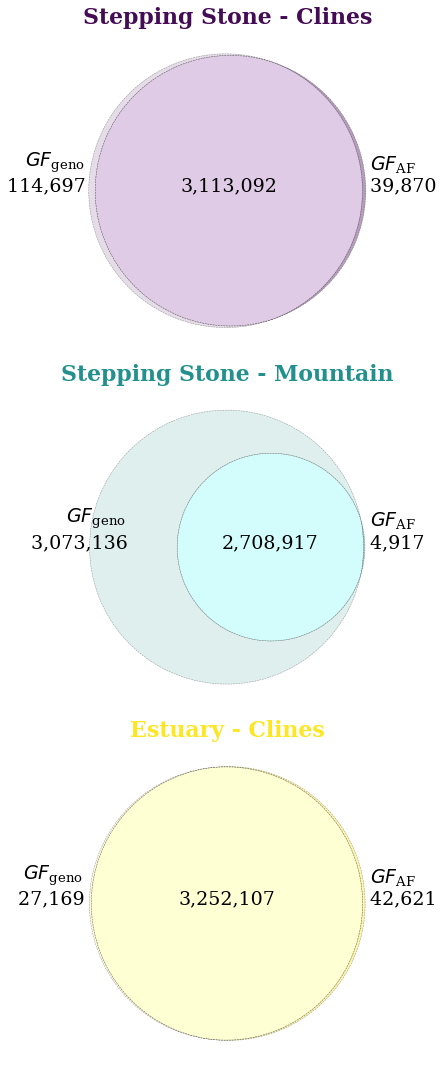

glevel
0 Text(-0.5166846342162323, 4.7299171712854954e-18, '1066104') (-0.5166846342162323, 4.7299171712854954e-18)
1 Text(0.5304782990503907, 0.0, '28682') (0.5304782990503907, 0.0)
2 Text(0.0455195371396053, 2.969515977462534e-17, '2987643') (0.0455195371396053, 2.969515977462534e-17)
0 Text(-0.5167735943605054, 4.728057440365613e-18, '1073105') (-0.5167735943605054, 4.728057440365613e-18)
1 Text(0.5305140715506511, 0.0, '28211') (0.5305140715506511, 0.0)
2 Text(0.04547775746220645, 2.9699908475932205e-17, '3011644') (0.04547775746220645, 2.9699908475932205e-17)
0 Text(-0.517473397933474, 4.647970652556299e-18, '1075793') (-0.517473397933474, 4.647970652556299e-18)
1 Text(0.5308735086596907, 0.0, '30515') (0.5308735086596907, 0.0)
2 Text(0.044653615979870664, 2.977238176260556e-17, '3074829') (0.044653615979870664, 2.977238176260556e-17)
Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/04_check_overlap_of_loci/glevel_venn_diagrams.pdf


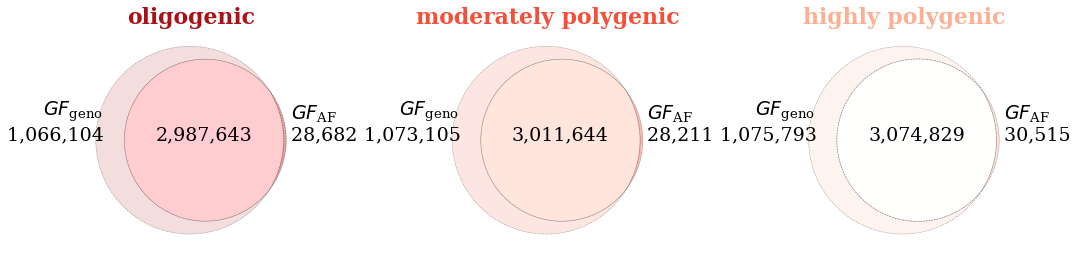

pleio
0 Text(-0.5170721251242291, 4.687366634480102e-18, '1613149') (-0.5170721251242291, 4.687366634480102e-18)
1 Text(0.5306746175555075, 0.0, '44947') (0.5306746175555075, 0.0)
2 Text(0.04507649943757741, 2.973430905125507e-17, '4565591') (0.04507649943757741, 2.973430905125507e-17)
0 Text(-0.5168890001614264, 4.715990111179801e-18, '1601853') (-0.5168890001614264, 4.715990111179801e-18)
1 Text(0.5305719670885439, 0.0, '42461') (0.5305719670885439, 0.0)
2 Text(0.0453504651100487, 2.971124796377177e-17, '4508525') (0.0453504651100487, 2.971124796377177e-17)
Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/04_check_overlap_of_loci/pleio_venn_diagrams.pdf


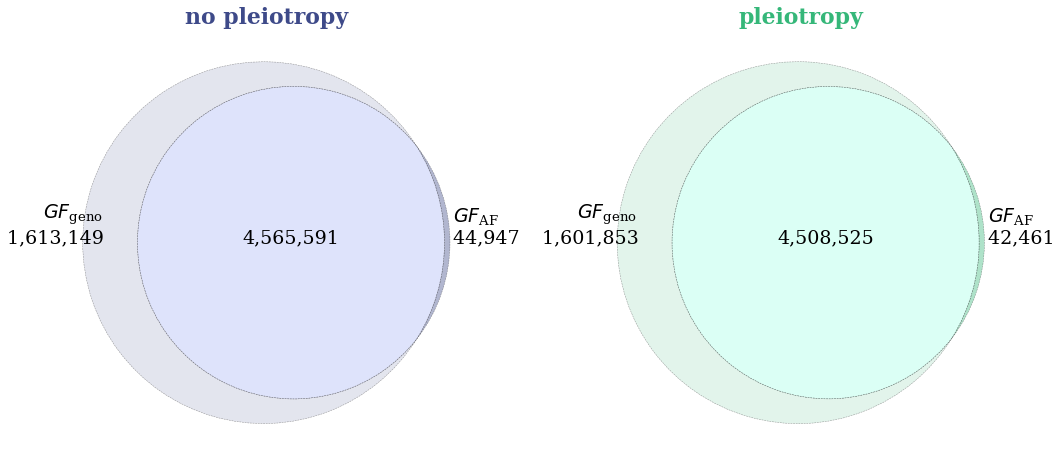

slevel
0 Text(-0.5185113380090398, 4.574377443305553e-18, '1590607') (-0.5185113380090398, 4.574377443305553e-18)
1 Text(0.5313627709849933, 0.0, '42251') (0.5313627709849933, 0.0)
2 Text(0.043778342947217164, 2.985593545552778e-17, '4651090') (0.043778342947217164, 2.985593545552778e-17)
0 Text(-0.5153825090240041, 4.833433279486669e-18, '1624395') (-0.5153825090240041, 4.833433279486669e-18)
1 Text(0.5298712618513626, 0.0, '45157') (0.5298712618513626, 0.0)
2 Text(0.04671235430617765, 2.9584950480237134e-17, '4423026') (0.04671235430617765, 2.9584950480237134e-17)
Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/04_check_overlap_of_loci/slevel_venn_diagrams.pdf


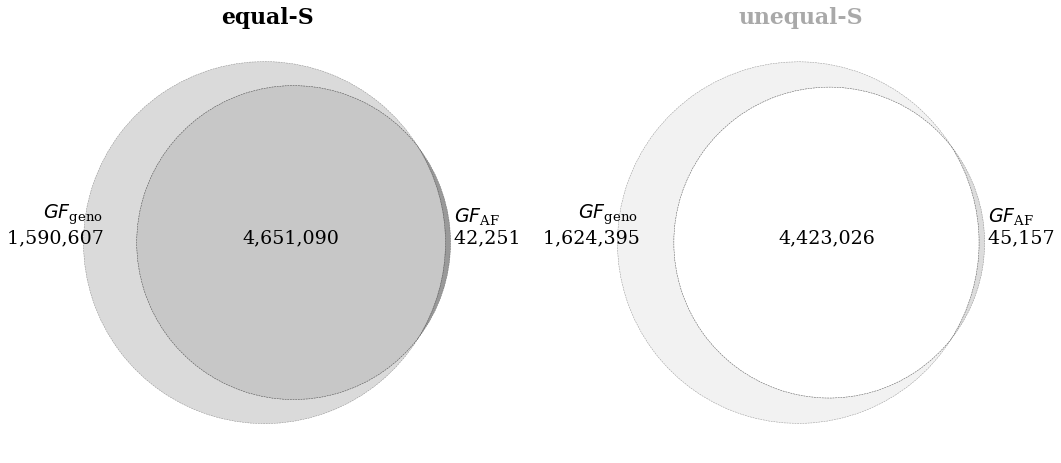

popsize
0 Text(-0.5141354009535641, 4.838648476607692e-18, '1297966') (-0.5141354009535641, 4.838648476607692e-18)
1 Text(0.5293826717398205, 0.0, '49746') (0.5293826717398205, 0.0)
2 Text(0.04713419860185533, 2.9529202451105364e-17, '3470635') (0.04713419860185533, 2.9529202451105364e-17)
0 Text(-0.5333577019252743, 3.3380401415531e-18, '499326') (-0.5333577019252743, 3.3380401415531e-18)
1 Text(0.5394729723766596, 0.0, '4930') (0.5394729723766596, 0.0)
2 Text(0.03031480148683155, 3.117694621199745e-17, '2186555') (0.03031480148683155, 3.117694621199745e-17)
0 Text(-0.5047574772261009, 5.9037912703565705e-18, '766527') (-0.5047574772261009, 5.9037912703565705e-18)
1 Text(0.5249382034832449, 0.0, '9741') (0.5249382034832449, 0.0)
2 Text(0.058298477292321266, 2.85734423517356e-17, '1650142') (0.058298477292321266, 2.85734423517356e-17)
0 Text(-0.5149138482081229, 4.8017422763331024e-18, '651183') (-0.5149138482081229, 4.8017422763331024e-18)
1 Text(0.5297203311485944, 0.0, '22991') (0.5

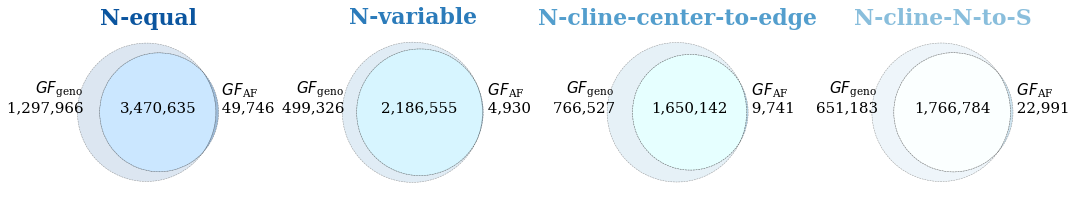

migration
0 Text(-0.507862975620301, 5.4262502000089894e-18, '2147982') (-0.507862975620301, 5.4262502000089894e-18)
1 Text(0.5266050053448921, 0.0, '67620') (0.5266050053448921, 0.0)
2 Text(0.053679710265631064, 2.895832244273173e-17, '5007987') (0.053679710265631064, 2.895832244273173e-17)
0 Text(-0.5333577019252743, 3.3380401415531e-18, '499326') (-0.5333577019252743, 3.3380401415531e-18)
1 Text(0.5394729723766596, 0.0, '4930') (0.5394729723766596, 0.0)
2 Text(0.03031480148683155, 3.117694621199745e-17, '2186555') (0.03031480148683155, 3.117694621199745e-17)
0 Text(-0.523469693626787, 4.1389270005731285e-18, '567694') (-0.523469693626787, 4.1389270005731285e-18)
1 Text(0.5339058429885393, 0.0, '14858') (0.5339058429885393, 0.0)
2 Text(0.03901497843675747, 3.030332566003029e-17, '1879574') (0.03901497843675747, 3.030332566003029e-17)
Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/04_check_overlap_of_loci/migration_venn_diagrams.pdf


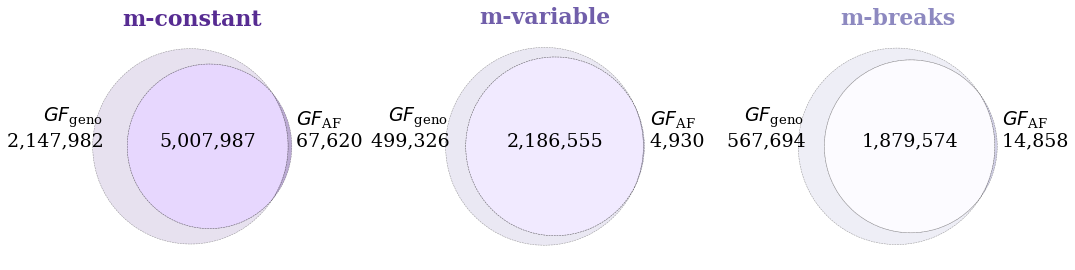

In [18]:
# landscape venn subsequently edited in inkscape to align MTN GF_geno count
sets = wrap_defaultdict(dict, 3)
for param in overlap_params:
    print(ColorText(param).bold())

    if param == 'landscape':
        fig, axes = plt.subplots(nrows=len(rt.hue_order[param]), figsize=(15, 15))
    else:
        fig, axes = plt.subplots(ncols=len(rt.hue_order[param]), figsize=(15, 15))

    for ax, paramlevel in zip(axes, rt.hue_order[param]):
        # create a color map
        paramlevel_color = rt.boxplot_kwargs['palette'][paramlevel]
        colors = mf.create_cmap(['white', paramlevel_color], name='', grain=15)

        df = overlaps[overlaps[param] == paramlevel].copy()

        sets[param][paramlevel]['ind'] = df['num_ind_loci'].sum() - df.overlap.sum()
        sets[param][paramlevel]['pooled'] = df['num_pooled_loci'].sum() - df.overlap.sum()
        sets[param][paramlevel]['overlap'] = df.overlap.sum()

        venn = venn2(
            subsets=values(sets[param][paramlevel]),
            set_labels=None, #keys(sets[param][paramlevel]),
            set_colors=[colors(5), colors(14), colors(1)],
            ax=ax
        )

        ax.set_title(rt.factor_names[paramlevel], fontsize=22, y=1, weight='bold',
                     color=rt.boxplot_kwargs['palette'][paramlevel])

        for i, label in enumerate(venn.subset_labels):
            xy = label.get_position()
            print(i, label, xy)
            text = '{:,}'.format(int(label.get_text()))
            label.remove()

#             set_label = rt.factor_names['ind'] if i == 0 else rt.factor_names['pooled'] if i == 1 else ''
            set_label = rt.factor_names['geno-model'] if i == 0 else rt.factor_names['af-model'] if i == 1 else ''

            ax.text(
                *xy,
                f'{set_label}  \n{text} ' if i == 0 else f' {set_label}\n {text}' if i == 1 else text,
                fontsize=19 if param != 'popsize' else 15,
                ha='right' if i == 0 else 'left' if i == 1 else 'center'
            )

        for circle in venn.patches:
            circle.set_linestyle('--')
            circle.set_linewidth(0.5)
            circle.set_edgecolor('k')

    plt.tight_layout()
    mf.save_pdf(f'{figdir}/{param}_venn_diagrams.pdf')
    plt.show()

In [7]:
venn.subset_labels

[Text(-0.523469693626787, 4.1389270005731285e-18, '567694'),
 Text(0.5339058429885393, 0.0, '14858'),
 Text(0.03901497843675747, 3.030332566003029e-17, '1879574')]

<a id='hist'></a>
### histograms

I don't like the histograms because binwidth isn't really compatible across figs, and makes interpretation difficult

[top](#home)

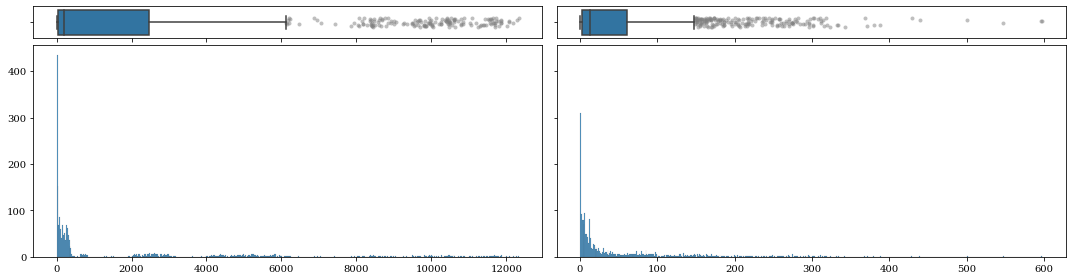

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 4), sharey=True)
for ax, source_loci in zip(axes, ['num_ind_loci', 'num_pooled_loci']):
    # max diff
    xmax = (overlaps[source_loci] - overlaps.overlap).max()  # if I wanted to control histbin width across figs
    
    mf.histo_box(
        (overlaps[source_loci] - overlaps.overlap).tolist(),
#         histbins=round(xmax / 10),
        histbins=500,
        ax=ax
    )
    
plt.tight_layout()

<a id='box'></a>
### boxplots

[top](#home)

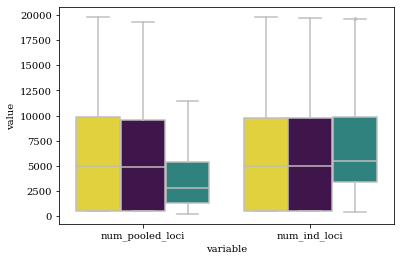

In [9]:
data = overlaps[['num_pooled_loci', 'num_ind_loci', 'seed']].melt(id_vars='seed')
data['landscape'] = data.seed.map(params.landscape)

g = sns.boxplot(
    data=data,
    y='value',
    x='variable',
    hue='landscape',
    **rt.boxplot_kwargs
)

g.legend_.remove()

<a id='scat'></a>
### scatter plots

[top](#home)

Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/04_check_overlap_of_loci/percent_of_total_overlap_scatter.pdf


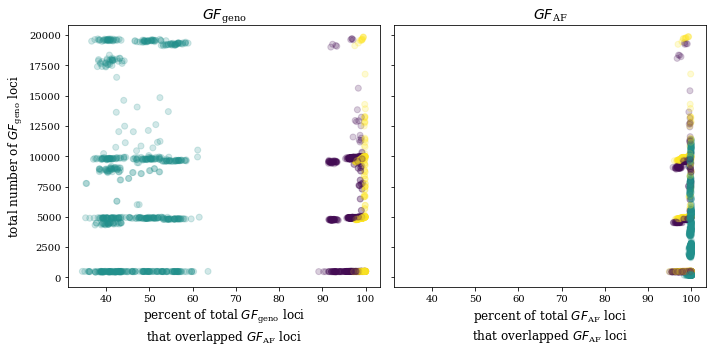

In [10]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)

for ax, source_loci in zip(axes.flat, ['num_ind_loci', 'num_pooled_loci']):
#     model = rt.factor_names['ind'] if 'ind' in source_loci else rt.factor_names['pooled']
#     model2 = rt.factor_names['ind'] if 'pooled' in source_loci else rt.factor_names['pooled']
    
    model = rt.factor_names['geno-model'] if 'ind' in source_loci else rt.factor_names['af-model']
    model2 = rt.factor_names['af-model'] if 'pooled' in source_loci else rt.factor_names['af-model']
    
    ax.scatter(
        (overlaps.overlap.astype(int) / overlaps[source_loci].astype(int)) * 100,
        overlaps[source_loci].astype(int),
        c=overlaps.landscape.map(rt.boxplot_kwargs['palette']),
        alpha=0.2
    )

    ax.set_xlabel(f'percent of total {model} loci\nthat overlapped {model2} loci', fontsize=12)
    ax.set_title(model, fontsize=14)
    if source_loci == 'num_ind_loci':
        ax.set_ylabel(f'total number of {model} loci', fontsize=12)
""
plt.tight_layout()
mf.save_pdf(f'{figdir}/percent_of_total_overlap_scatter.pdf')
plt.show()

Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/04_check_overlap_of_loci/num_loci_subplots_scatter_num_loci_pooled_vs_ind.pdf


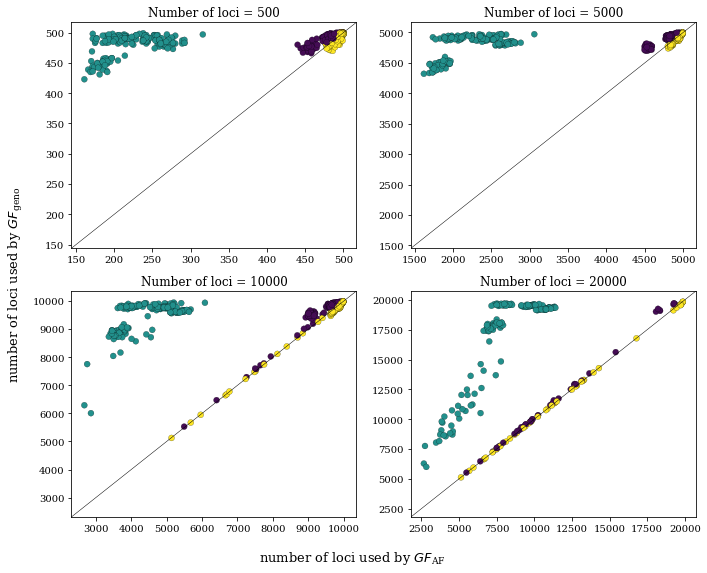

In [11]:
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 8))
for ax, num_loci in zip(axes.flat, overlaps.num_loci.unique()):
    df = overlaps[overlaps.num_loci == num_loci].copy()
    ax.scatter(
        df.num_pooled_loci,
        df.num_ind_loci,
        c = df.landscape.map(rt.boxplot_kwargs['palette']),
        edgecolor='k',
        linewidth=0.2
    )
    name = rt.factor_names['num_loci']
    ax.set_title(f"{name} = {int(num_loci)}")
    mf.draw_xy(ax)
    
# fig.supxlabel(f'number of loci used by {rt.factor_names["pooled"]}', fontsize=13)
# fig.supylabel(f'number of loci used by {rt.factor_names["ind"]}', fontsize=13)
fig.supxlabel(f'number of loci used by {rt.factor_names["af-model"]}', fontsize=13)
fig.supylabel(f'number of loci used by {rt.factor_names["geno-model"]}', fontsize=13)

plt.tight_layout()
mf.save_pdf(f'{figdir}/num_loci_subplots_scatter_num_loci_pooled_vs_ind.pdf')
plt.show()

In [12]:
overlaps.head()

,seed,rep,num_loci,overlap,num_ind_loci,num_pooled_loci,landscape,glevel,pleio,slevel,popsize,migration
0,1231109,run_20220919_0-225,00500,491,495,495,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-cline-center-to-edge,m-constant
1,1231110,run_20220919_0-225,00500,484,487,494,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-cline-N-to-S,m-constant
2,1231111,run_20220919_0-225,00500,493,495,497,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-equal,m-breaks
3,1231112,run_20220919_0-225,00500,479,490,485,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-equal,m-constant
4,1231113,run_20220919_0-225,00500,497,498,499,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-variable,m-variable


In [13]:
# save
f = f'{figdir}/overlaps.txt'

overlaps.to_csv(f, sep='\t', index=False)

f

'/work/lotterhos/brandon/runtime/figures/05_supplemental/04_check_overlap_of_loci/overlaps.txt'

In [14]:
formatclock(dt.now() - t0)

'0-00:02:59'

In [15]:
pkl = f'{figdir}/loci.pkl'

pkldump(loci, pkl)

pkl

'/work/lotterhos/brandon/runtime/figures/05_supplemental/04_check_overlap_of_loci/loci.pkl'

# make comparing number of loci used by GF_geno and GF_AF

get counts of loci used by GF_geno and GF_AF models (not just the overlapping loci, as above)

In [1]:
from pythonimports import *
import myfigs as mf

import runtime_API as rt
import MVP_summary_functions as mvp

import seaborn as sns

figdir = f'{rt.resdir}/figures/05_supplemental/04_check_overlap_of_loci'

t0 = dt.now()

rt.latest_commit()
session_info.show()

#########################################################
Today:	September 26, 2024 - 12:52:38 EDT
python version: 3.8.5
conda env: mvp_env

Current commit of pythonimports:
commit 6a767410e7b569adbf9df526de108f22ef50aad8  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Wed Mar 6 13:42:13 2024 -0700

Current commit of MVP_offsets:
commit 5ce82f4d655645237a0f4026fa32e220226dc373  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Thu May 16 13:02:58 2024 -0400

Current commit of MVP_runtime:
commit df87dd2c708ac0fdeebcfaaca239473ca2c487af  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Tue Mar 19 16:17:46 2024 -0400
#########################################################



# get metadata

In [2]:
# get simulation metadata
params = mvp.read_params_file()

params.head()

100%|███████████████| 2250/2250 [00:02<00:00, 864.84it/s]


,level,reps,arch,demog_name,demog_level_sub,demog_level,MIG_x,MIG_y,xcline,ycline,demog,METAPOP_SIDE_x,METAPOP_SIDE_y,Nequal,isVariableM,MIG_breaks,arch_level_sub,arch_level,MU_base,MU_QTL_proportion,SIGMA_QTN_1,SIGMA_QTN_2,SIGMA_K_1,SIGMA_K_2,N_traits,ispleiotropy,seed,final_LA,glevel,plevel,pleio,slevel,landscape,popsize,migration,landscape-slevel
1231094,highly-polygenic_1-trait__Est-Clines_N-cline-c...,1,highly-polygenic_1-trait,Est-Clines_N-cline-center-to-edge_m-constant,N-cline-center-to-edge_m-constant,Est-Clines,0.49,0.07,linear,linear,Estuary,10,10,4,0,0,1-trait,highly-polygenic,1.000000e-07,0.25,0.002,0.002,0.5,0.5,1,0,1231094,0.500854,highly-polygenic,1-trait,no pleiotropy,NaN,Est-Clines,N-cline-center-to-edge,m-constant,Est-Clines_1-trait
1231095,highly-polygenic_1-trait__Est-Clines_N-cline-N...,1,highly-polygenic_1-trait,Est-Clines_N-cline-N-to-S_m-constant,N-cline-N-to-S_m-constant,Est-Clines,0.49,0.07,linear,linear,Estuary,10,10,2,0,0,1-trait,highly-polygenic,1.000000e-07,0.25,0.002,0.002,0.5,0.5,1,0,1231095,0.505075,highly-polygenic,1-trait,no pleiotropy,NaN,Est-Clines,N-cline-N-to-S,m-constant,Est-Clines_1-trait
1231096,highly-polygenic_1-trait__Est-Clines_N-equal_m...,1,highly-polygenic_1-trait,Est-Clines_N-equal_m_breaks,N-equal_m_breaks,Est-Clines,0.49,0.07,linear,linear,Estuary,10,10,0,0,1,1-trait,highly-polygenic,1.000000e-07,0.25,0.002,0.002,0.5,0.5,1,0,1231096,0.499265,highly-polygenic,1-trait,no pleiotropy,NaN,Est-Clines,N-equal,m-breaks,Est-Clines_1-trait
1231097,highly-polygenic_1-trait__Est-Clines_N-equal_m...,1,highly-polygenic_1-trait,Est-Clines_N-equal_m-constant,N-equal_m-constant,Est-Clines,0.49,0.07,linear,linear,Estuary,10,10,0,0,0,1-trait,highly-polygenic,1.000000e-07,0.25,0.002,0.002,0.5,0.5,1,0,1231097,0.499365,highly-polygenic,1-trait,no pleiotropy,NaN,Est-Clines,N-equal,m-constant,Est-Clines_1-trait
1231098,highly-polygenic_1-trait__Est-Clines_N-variabl...,1,highly-polygenic_1-trait,Est-Clines_N-variable_m-variable,N-variable_m-variable,Est-Clines,0.49,0.07,linear,linear,Estuary,10,10,3,1,0,1-trait,highly-polygenic,1.000000e-07,0.25,0.002,0.002,0.5,0.5,1,0,1231098,0.501054,highly-polygenic,1-trait,no pleiotropy,NaN,Est-Clines,N-variable,m-variable,Est-Clines_1-trait


# get loci with positive R2

In [3]:
# created in first part of notebook above
pkl = f'{figdir}/loci.pkl'

loci = pklload(pkl)

# get locus count data

In [4]:
# get counts of loci with positive R2 for ind and pooled runs

# NOTE - this is DIFFERENT than how I did it above
# doing it this way I ensure I get locus counts for all completed replicate training
# doing so results in seeing more replicats for pooled than ind, because some ind jobs failed    

count_data = pd.DataFrame(columns=['seed', 'rep', 'num_loci', 'overlap', 'num_ind_loci', 'num_pooled_loci'])
for rep, repdirs in rt.dirs['ind'].items():
    for repdir in repdirs:
        num_loci = op.basename(repdir)
        
        for seed, pool_loci in loci['pooled'][rep][num_loci].items():  # this line was changed from ind to pooled
            ind_loci = loci['ind'][rep][num_loci][seed]  # this line was changed from pooled to ind
                # note that `loci` is a defaultdict, and will return 0 when a new key is tried
                    # this happens when the seed from pooled is not found in the ind keys of the `loci` dict
                    # i replace these zeros with np.nan in cells below so that figs are not affected

            count_data.loc[nrow(count_data), : ] = (
                seed,
                rep,
                num_loci,
                len(set(ind_loci).intersection(pool_loci)),
                len(ind_loci),
                len(pool_loci)
            )

# add metadata to dataframe
overlap_params = []
for param in rt.hue_order.keys():
    if param in ['source', 'noncausal_env', 'marker_set', 'program', 'num_loci', 'demography', 'final_la_bin', 'model']:
        continue
    count_data[param] = count_data.seed.map(params[param])
    overlap_params.append(param)
    
count_data

,seed,rep,num_loci,overlap,num_ind_loci,num_pooled_loci,landscape,glevel,pleio,slevel,popsize,migration
0,1231109,run_20220919_0-225,00500,491,495,495,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-cline-center-to-edge,m-constant
1,1231110,run_20220919_0-225,00500,484,487,494,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-cline-N-to-S,m-constant
2,1231111,run_20220919_0-225,00500,493,495,497,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-equal,m-breaks
3,1231112,run_20220919_0-225,00500,479,490,485,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-equal,m-constant
4,1231113,run_20220919_0-225,00500,497,498,499,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-variable,m-variable
...,...,...,...,...,...,...,...,...,...,...,...,...
2155,1231764,run_20220919_450-675,20000,7492,19572,7509,SS-Mtn,oligogenic,pleiotropy,unequal-S,N-cline-center-to-edge,m-constant
2156,1231765,run_20220919_450-675,20000,10045,19571,10072,SS-Mtn,oligogenic,pleiotropy,unequal-S,N-cline-N-to-S,m-constant
2157,1231766,run_20220919_450-675,20000,10771,19198,10782,SS-Mtn,oligogenic,pleiotropy,unequal-S,N-equal,m-breaks
2158,1231767,run_20220919_450-675,20000,6840,17877,6859,SS-Mtn,oligogenic,pleiotropy,unequal-S,N-equal,m-constant


### clean up locus count data

In [5]:
# there should be no pooled runs with no loci with positive R2
(count_data['num_pooled_loci'] == 0).sum()

0

In [6]:
# there were 269 reps that failed
(count_data['num_ind_loci'] == 0).sum()

269

In [7]:
# the failed reps have 0 entered
count_data.loc[count_data['num_ind_loci'] == 0].head()

,seed,rep,num_loci,overlap,num_ind_loci,num_pooled_loci,landscape,glevel,pleio,slevel,popsize,migration
541,1231110,run_20220919_0-225,20000,0,0,19757,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-cline-N-to-S,m-constant
542,1231111,run_20220919_0-225,20000,0,0,19728,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-equal,m-breaks
543,1231112,run_20220919_0-225,20000,0,0,19475,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-equal,m-constant
545,1231114,run_20220919_0-225,20000,0,0,19324,SS-Clines,highly-polygenic,no pleiotropy,equal-S,N-cline-center-to-edge,m-constant
546,1231115,run_20220919_0-225,20000,0,0,19316,SS-Clines,highly-polygenic,no pleiotropy,equal-S,N-cline-N-to-S,m-constant


In [8]:
# replace the zeros with np.nan
count_data.loc[count_data['num_ind_loci'] == 0, 'overlap'] = np.nan
count_data.loc[count_data['num_ind_loci'] == 0, 'num_ind_loci'] = np.nan

count_data.loc[count_data['num_ind_loci'].isnull()]

,seed,rep,num_loci,overlap,num_ind_loci,num_pooled_loci,landscape,glevel,pleio,slevel,popsize,migration
541,1231110,run_20220919_0-225,20000,NaN,NaN,19757,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-cline-N-to-S,m-constant
542,1231111,run_20220919_0-225,20000,NaN,NaN,19728,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-equal,m-breaks
543,1231112,run_20220919_0-225,20000,NaN,NaN,19475,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-equal,m-constant
545,1231114,run_20220919_0-225,20000,NaN,NaN,19324,SS-Clines,highly-polygenic,no pleiotropy,equal-S,N-cline-center-to-edge,m-constant
546,1231115,run_20220919_0-225,20000,NaN,NaN,19316,SS-Clines,highly-polygenic,no pleiotropy,equal-S,N-cline-N-to-S,m-constant
...,...,...,...,...,...,...,...,...,...,...,...,...
2148,1231757,run_20220919_450-675,20000,NaN,NaN,19340,Est-Clines,oligogenic,pleiotropy,unequal-S,N-equal,m-constant
2150,1231759,run_20220919_450-675,20000,NaN,NaN,19274,SS-Clines,oligogenic,pleiotropy,unequal-S,N-cline-center-to-edge,m-constant
2151,1231760,run_20220919_450-675,20000,NaN,NaN,19245,SS-Clines,oligogenic,pleiotropy,unequal-S,N-cline-N-to-S,m-constant
2152,1231761,run_20220919_450-675,20000,NaN,NaN,19251,SS-Clines,oligogenic,pleiotropy,unequal-S,N-equal,m-breaks


<a id='comp'></a>
# make a fig

[top](#home)

In [9]:
rt.factor_names['num_loci']

'Number of loci'

Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/04_check_overlap_of_loci/ind_true_locus_counts.pdf


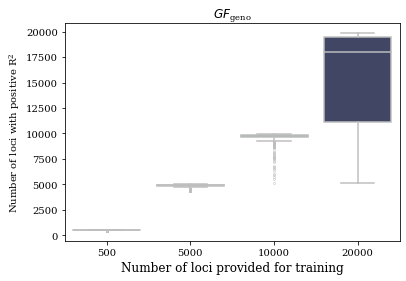

Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/04_check_overlap_of_loci/pooled_true_locus_counts.pdf


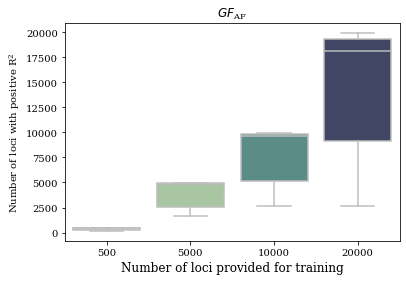

In [10]:
for source in ['ind', 'pooled']:
    model = 'geno-model' if source == 'ind' else 'af-model'
    
    data = count_data.copy().astype({'num_loci' : str})
    data.num_loci = data.num_loci.str.lstrip('0')
    
    g = sns.boxplot(
        data=data,
        x='num_loci',
        y=f'num_{source}_loci',
        **rt.boxplot_kwargs
    )
    
    g.axes.set_title(rt.factor_names[model])
    
    g.axes.set_xlabel(rt.factor_names['num_loci'] + ' provided for training', fontsize=12)
    g.axes.set_ylabel('Number of loci with positive R$^{2}$')

    mf.save_pdf(f'{figdir}/{source}_true_locus_counts.pdf')
    plt.show()

In [11]:
formatclock(dt.now() - t0)

'0-00:00:11'